In [1]:
pip install numpy pandas matplotlib requests seaborn scikit-learn

Mean Squared Error: 0.00046221208038261505


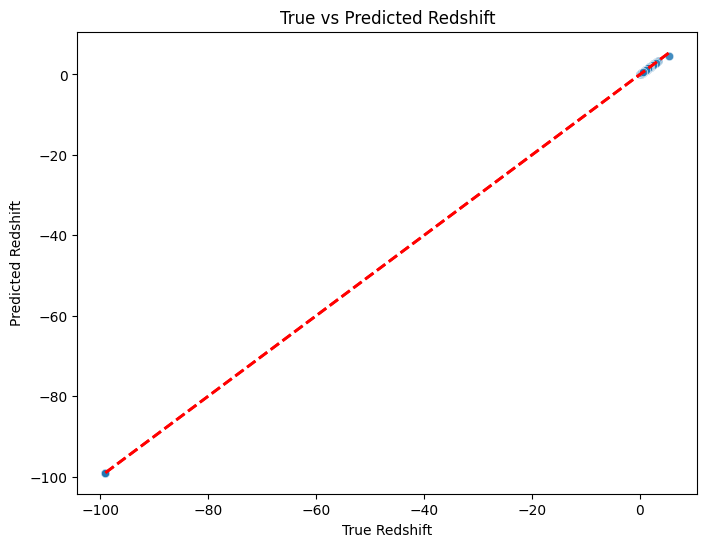

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Step 1: Load the .xlsx file from GitHub
url = 'https://github.com/Adrita-Khan/AstroPhotoZ/raw/main/Datasets/Stripe_82X/final_stripe_82X_photozs_brown.xlsx'
response = requests.get(url)

# Ensure successful request
response.raise_for_status()

# Load the Excel data into a pandas DataFrame
xls = BytesIO(response.content)
df = pd.read_excel(xls, sheet_name=None)

# The sheet name might be "Sheet1" or another default name, so let's inspect the keys first
df.keys()

# Load the first sheet into a DataFrame (assuming the data is on the first sheet)
data = df[list(df.keys())[0]]

# Step 2: Preprocessing
# Check for missing values
data.isnull().sum()

# For simplicity, let's drop rows where the target variable 'REDSHIFT' is missing
data = data.dropna(subset=['REDSHIFT'])


# Define the list of relevant columns for estimating photometric redshift
features = [
    'MAG_FUV', 'MAGERR_FUV', 'MAG_NUV', 'MAGERR_NUV',
    'U', 'UERR', 'G', 'GERR', 'R', 'RERR', 'I', 'IERR', 'Z', 'ZERR',
    'J', 'JERR', 'H', 'HERR', 'K', 'KERR', 'W1', 'W1ERR', 'W2', 'W2ERR',
    'PHOTOZ', 'PHOTOZ_BEST68_LOW', 'PHOTOZ_BEST68_HIGH', 'PHOTOZ_ML',
    'PHOTOZ_ML68_LOW', 'PHOTOZ_ML68_HIGH',
    'REDSHIFT', 'REDSHIFT_ERR', 'REDSHIFT_SOURCE',
    'SOFT_FLUX', 'HARD_FLUX', 'FULL_FLUX',
    'CHI_BEST', 'MOD_BEST', 'EXTLAW_BEST', 'EBV_BEST'
]

# Ensure that all features are numerical
data = data[features + ['REDSHIFT']]

# Convert any categorical variables (if present) to numerical using LabelEncoder
encoder = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = encoder.fit_transform(data[col])

# Step 3: Train-test split
X = data[features]
y = data['REDSHIFT']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Building the model
# We'll use a RandomForestRegressor to predict photometric redshift

# Create a pipeline with an imputer and regressor
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # Handle missing values
    RandomForestRegressor(n_estimators=100, random_state=42)
)

# Train the model
pipeline.fit(X_train, y_train)

# Step 5: Evaluate the model
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Step 6: Visualize the results
# Plotting the true vs predicted redshift
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('True vs Predicted Redshift')
plt.show()



Best Parameters: {'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100}
Mean Squared Error: 0.07415809434771808
Cross-validated MSE: 6.805405378796595 ± 6.627844658561125


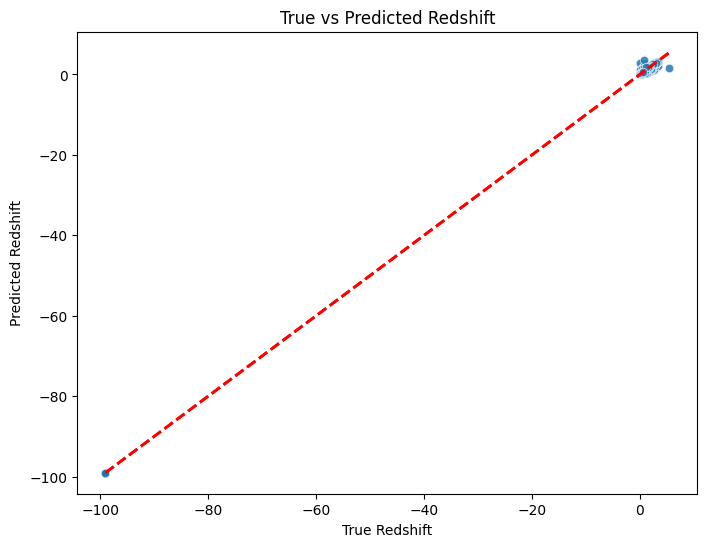

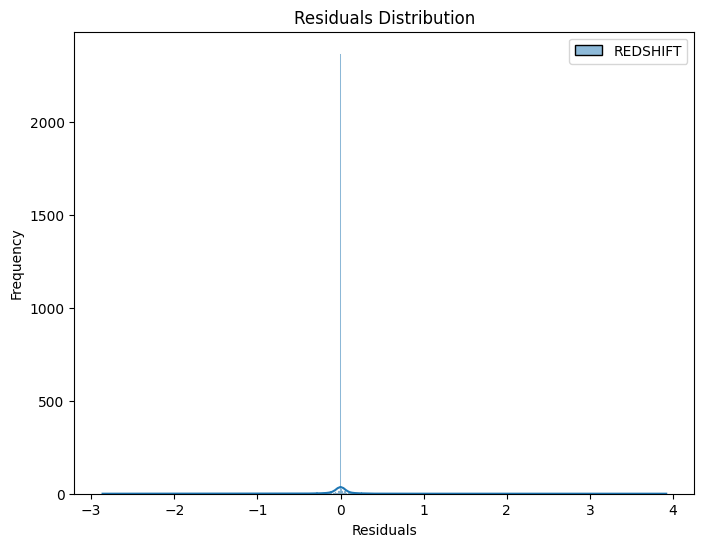

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Step 1: Load Data from GitHub
def load_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if request was successful
        xls = BytesIO(response.content)
        df = pd.read_excel(xls, sheet_name=None)
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error loading data: {e}")
        return None

# Step 2: Preprocess Data
def preprocess_data(data):
    data = data.dropna(subset=['REDSHIFT'])  # Drop rows with missing target 'REDSHIFT'

    # Define relevant columns for estimating photometric redshift
    features = [
        'MAG_FUV', 'MAGERR_FUV', 'MAG_NUV', 'MAGERR_NUV', 'U', 'UERR', 'G', 'GERR',
        'R', 'RERR', 'I', 'IERR', 'Z', 'ZERR', 'J', 'JERR', 'H', 'HERR', 'K', 'KERR',
        'W1', 'W1ERR', 'W2', 'W2ERR', 'PHOTOZ', 'PHOTOZ_BEST68_LOW', 'PHOTOZ_BEST68_HIGH',
        'PHOTOZ_ML', 'PHOTOZ_ML68_LOW', 'PHOTOZ_ML68_HIGH', 'REDSHIFT', 'REDSHIFT_ERR',
        'REDSHIFT_SOURCE', 'SOFT_FLUX', 'HARD_FLUX', 'FULL_FLUX', 'CHI_BEST', 'MOD_BEST',
        'EXTLAW_BEST', 'EBV_BEST'
    ]

    data = data[features + ['REDSHIFT']]

    # Convert categorical variables to numerical
    encoder = LabelEncoder()
    for col in data.select_dtypes(include=['object']).columns:
        data[col] = encoder.fit_transform(data[col])

    return data

# Step 3: Train-Test Split
def split_data(data, target_column='REDSHIFT'):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Step 4: Build and Train Model with Hyperparameter Tuning
def build_model(X_train, y_train):
    # Create a pipeline with an imputer and regressor
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),  # Handle missing values
        RandomForestRegressor(n_estimators=100, random_state=42)
    )

    # Hyperparameter grid for tuning
    param_grid = {
        'randomforestregressor__n_estimators': [100, 200],
        'randomforestregressor__max_depth': [10, 20, None],
        'randomforestregressor__min_samples_split': [2, 5],
    }

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Step 5: Evaluate Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')

    # Cross-validation for more robust performance evaluation
    cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validated MSE: {-cv_scores.mean()} ± {cv_scores.std()}")

    return y_pred

# Step 6: Visualize Results
def visualize_results(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('True Redshift')
    plt.ylabel('Predicted Redshift')
    plt.title('True vs Predicted Redshift')
    plt.show()

    # Residuals plot
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

# Main Execution
if __name__ == "__main__":
    url = 'https://github.com/Adrita-Khan/AstroPhotoZ/raw/main/Datasets/Stripe_82X/final_stripe_82X_photozs_brown.xlsx'

    # Load and preprocess data
    df = load_data(url)
    if df:
        data = preprocess_data(df[list(df.keys())[0]])

        # Split data
        X_train, X_test, y_train, y_test = split_data(data)

        # Build, train, and evaluate model
        model = build_model(X_train, y_train)
        y_pred = evaluate_model(model, X_test, y_test)

        # Visualize results
        visualize_results(y_test, y_pred)
